In [1]:
include("/Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2/scripts/intro.jl")
using Graphs
using SimpleWeightedGraphs
using Dice 
using PrettyTables
using LinearAlgebra

using GraphPlot
using Plots
using StatsPlots
using HNProcess
using DataRefine
using PartitioningData
using IterTools
using Random

  Activating 

Currently active project is: HN_V2

Path of active project: /Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2

Have fun with your new project!

You can help us improve DrWatson by opening
issues on GitHub, submitting feature requests,
or even opening your own Pull Requests!



project at `~/Documents/Research Professor/Mikhail Erementchouk/HN_V2`


In [106]:
function sol_finder_test(state, params; d = false)
    rots = iterative_rotater_state(state, params)
    sol = []
    for st in rots
        if (reshape(st[1],size(params["images"][1],1),size(params["images"][1],2)) in params["images"] ||
            -1 .*reshape(st[1],size(params["images"][1],1),size(params["images"][1],2)) in params["images"])
            println("FOUND")
            if d
                pretty_table(reshape(st[1],size(params["images"][1],1),size(params["images"][1],2)))
            end
            push!(sol, st)
        end
    end
    return sol
end


sol_finder_test (generic function with 2 methods)

In [88]:
function HN_Solver_Traj_test(parameters::Dict{String, Any}, debug::Bool = false)
    # Just gets raw result, no visualizer

    scaling = parameters["scaling"] #Scaling coeff
    S = parameters["images"] # Images
    time_total= parameters["sim_time"] # how long the sim is
    num_steps = parameters["steps"] # number of steps in the sim
    dt_sim = parameters["delta"] # dt
    delta_t = time_total/num_steps
    traj_collection::Vector{Vector{Dice.Hybrid}} = []

    # Make Graph
    graph_set = get_HN_graph(S, scaling)
    
    # Making model
    model = Dice.Model(graph_set, Dice.model_2_hybrid_coupling, delta_t)

    # Making randomized initial state
    num_vertices = Graphs.nv(model.graph)
    
    converged = 0
    diverged = 0


    pinned::Vector{Tuple{Int64, Int8}} = []
    state::Dice.Hybrid = Dice.get_random_hybrid(num_vertices, 2.0)
    #println(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    for stim in parameters["initial_stimuli"]
        # Every n entries is a column, thus taking # of columns and subtracting 1 brings you to where the column begins
        # Adding 1 will bring you to the first entry in the column and so on for +k
        pos = (stim[2]-1) * size(parameters["images"][1],1) + stim[1]
        state[1][pos] = stim[3]
        push!(pinned, (pos, stim[3]))
    end
    @show pinned
    traj = Dice.trajectories_pinned(model.graph, num_steps, dt_sim, model.coupling, state, pinned)
    push!(traj_collection, traj)
    # Comment out the other part of the or conditional to ignore negative images
 #=   if (reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
        -1 .*reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
        converged += 1
        global sol = state[1]
        break
    end =#

    
    if debug
        pretty_table(reshape(traj[end][1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    end
    return(state,traj_collection)
end    

HN_Solver_Traj_test (generic function with 2 methods)

In [7]:

function unique_random_binary_images(num, cardinality)
    images = []
    i = 0
    if num > cardinality
        print("FAILED")
        return 
    end
    while i < num
        v = rand((-1,1),cardinality)
        if !(v in images || -1*v in images)
            push!(images, v)
            i += 1
        end
    end
    return reshape.(images, Int(sqrt(cardinality)), Int(sqrt(cardinality)))
end

unique_random_binary_images (generic function with 1 method)

In [73]:
set =unique_random_binary_images(15, 16)

15-element Vector{Matrix{Int64}}:
 [-1 1 -1 1; -1 -1 -1 1; 1 -1 -1 1; -1 1 -1 1]
 [1 1 1 -1; 1 -1 -1 1; -1 1 1 1; -1 -1 -1 1]
 [-1 -1 -1 1; 1 1 -1 -1; 1 -1 -1 -1; -1 -1 1 1]
 [-1 -1 1 -1; 1 -1 1 1; -1 1 -1 1; -1 -1 1 -1]
 [1 1 -1 -1; 1 -1 -1 1; 1 1 1 1; 1 -1 -1 -1]
 [-1 -1 1 1; 1 1 1 -1; -1 1 1 1; 1 1 -1 1]
 [1 1 1 -1; -1 1 1 -1; 1 1 1 -1; -1 1 -1 1]
 [-1 1 1 1; -1 -1 1 -1; 1 -1 1 1; 1 1 1 1]
 [-1 -1 1 -1; 1 1 1 -1; -1 -1 -1 1; -1 -1 -1 -1]
 [-1 -1 -1 -1; -1 1 1 -1; 1 -1 -1 -1; 1 1 -1 -1]
 [1 -1 1 1; -1 1 1 -1; 1 1 1 1; -1 1 -1 -1]
 [1 -1 1 -1; -1 1 -1 1; -1 -1 1 1; -1 1 1 1]
 [1 1 1 -1; -1 -1 -1 1; 1 -1 -1 -1; -1 -1 1 1]
 [-1 -1 -1 1; -1 -1 1 1; -1 -1 1 1; 1 1 -1 1]
 [-1 -1 -1 1; -1 -1 -1 -1; -1 1 1 1; 1 -1 -1 -1]

In [92]:
sim_time = 4
steps = 3000
parameters = Dict{String, Any}(
    "images" => set,
    "sim_time" => sim_time,
    "steps" => steps,
    "iterations" => 100, #Num of times attempted
    "num_agitations" => 1,
    "scaling" => 1.0,
    "delta" => -1* sim_time/steps,
    # This is the region that we will provide and the machine must keep this region constant
    # Will be a vector of tuples which are (row, col, state)
    "initial_stimuli" => [(1,1,1), (1,2,-1)]
)
println(length(parameters["images"]))

15


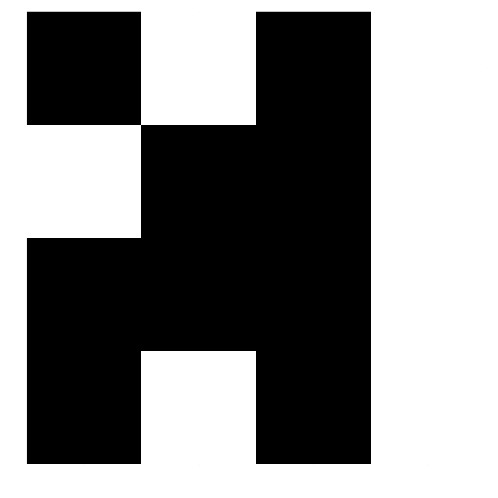

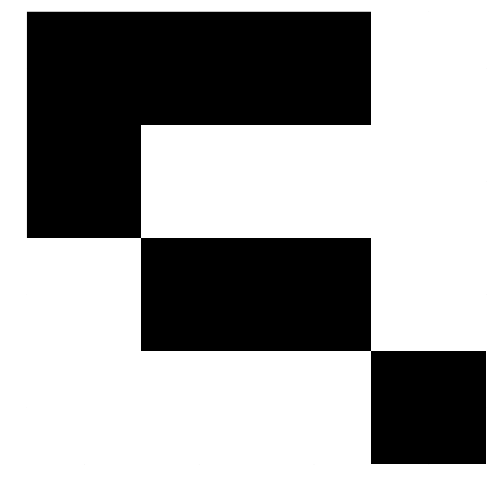

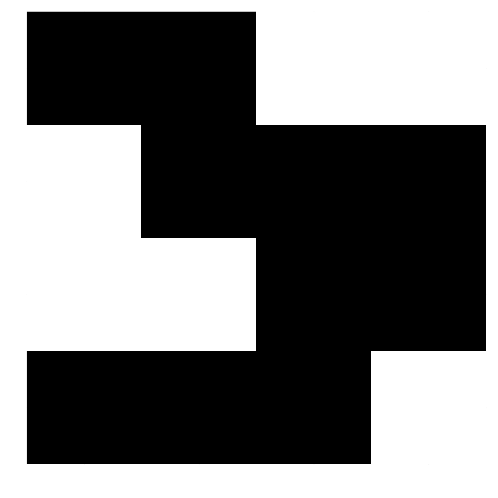

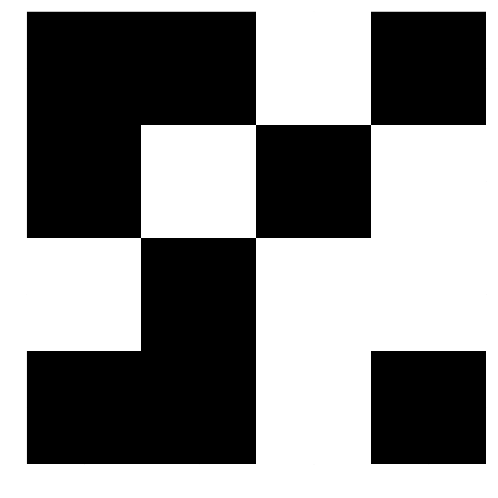

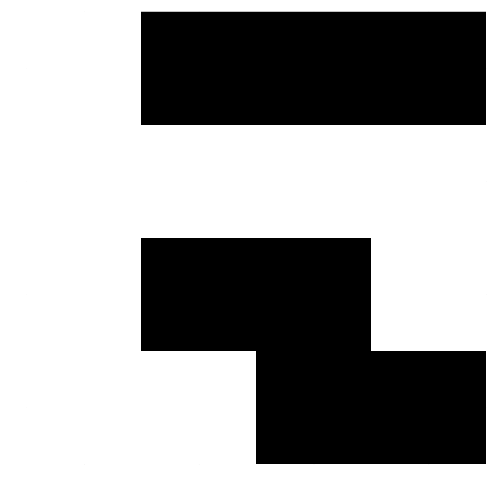

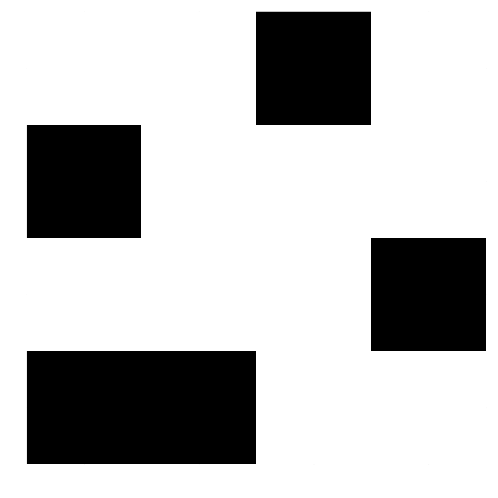

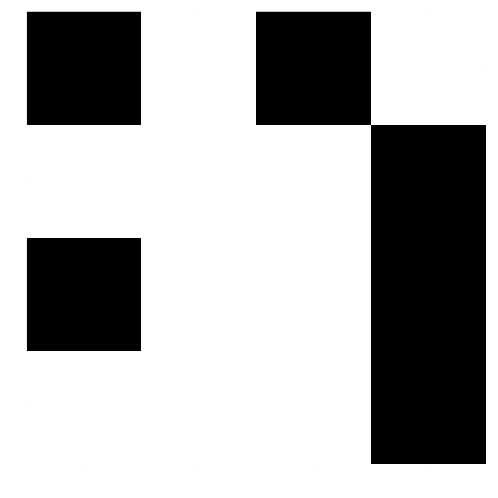

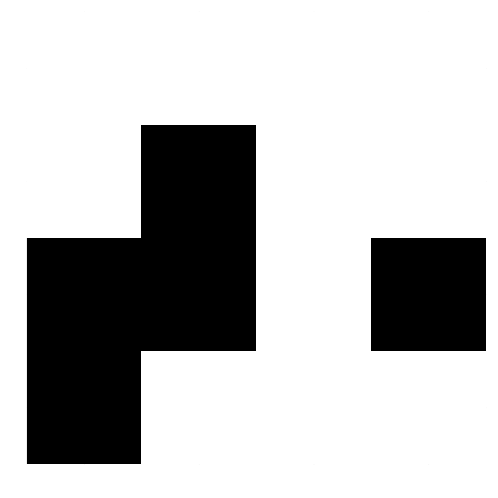

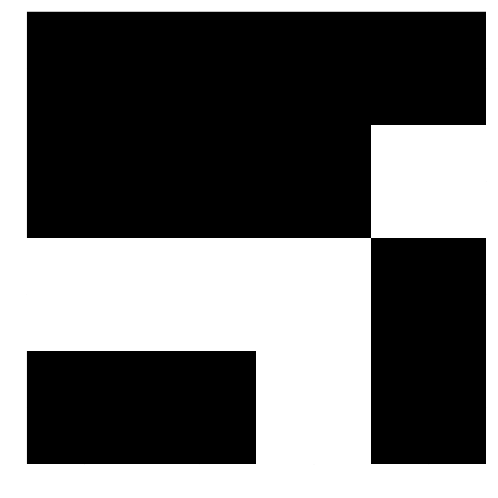

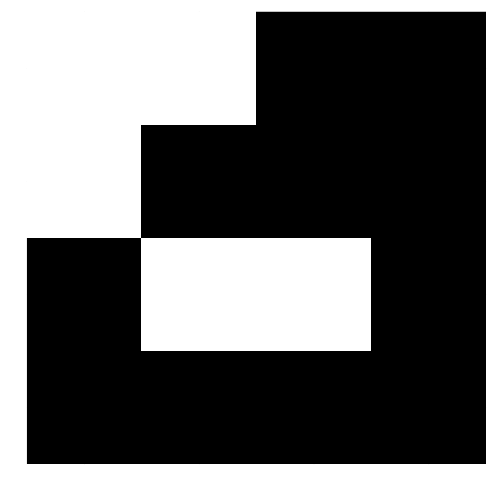

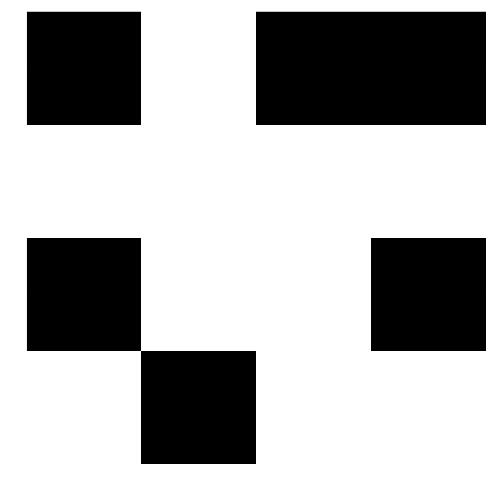

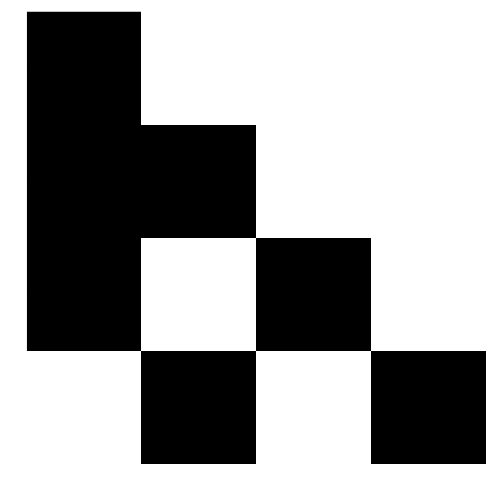

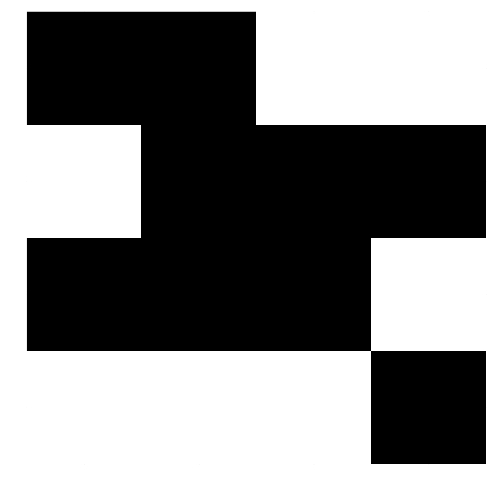

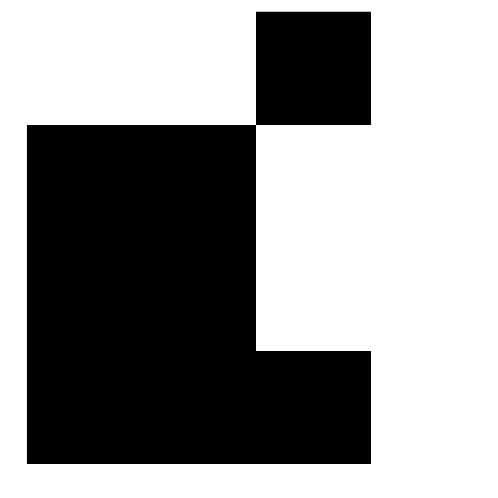

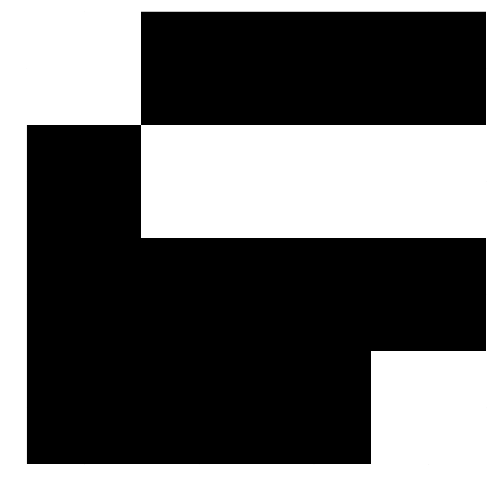

In [75]:
for i in parameters["images"]
    binary_image_visualizer(i, 500, "hi", d = true)
end

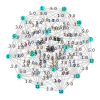

In [110]:
g = get_HN_graph(parameters["images"], parameters["scaling"])
elabels = [weights(g)[e.src, e.dst] for e in edges(g)]

# Plot with edge labels
 gplot(g, 
      nodelabel=1:nv(g), 
      edgelabel=round.(elabels, digits=2),)

In [111]:
println(is_connected(g))
println(maximum(weights(g)))
println(minimum(weights(g)))
pretty_table(Matrix(Graphs.weights(g)))

true
7.0
-9.0
┌────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │ Col. 6 │ Col. 7 │ Col. 8 │ Col. 9 │ Col. 10 │ Col. 11 │ Col. 12 │ Col. 13 │ Col. 14 │ Col. 15 │ Col. 16 │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│    0.0 │   -1.0 │    3.0 │   -5.0 │    7.0 │    1.0 │    5.0 │   -1.0 │    5.0 │    -5.0 │     5.0 │     1.0 │    -7.0 │     5.0 │    -3.0 │     1.0 │
│   -1.0 │    0.0 │   -5.0 │   -1.0 │   -1.0 │    1.0 │    5.0 │   -9.0 │    1.0 │    -1.0 │    -3.0 │     1.0 │    -3.0 │     1.0 │     1.0 │    -3.0 │
│    3.0 │   -5.0 │    0.0 │   -1.0 │    7.0 │    1.0 │   -3.0 │    3.0 │   -3.0 │    -1.0 │    -3.0 │     1.0 │     1.0 │    -3.0 │    -7.0 │     1.0 │
│   -5.0 │   -1.0 │   -1.0 │    0.0 │   -1.0 │   -3.0 │    1.0 │    

pinned = Tuple{Int64, Int8}[(1, 1), (5, -1)]


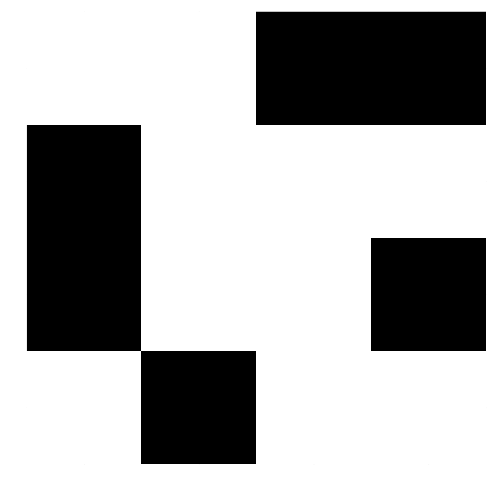

Any[]
(Int8[1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1], [0.0, -0.06822104613194731, -0.0060085038669206985, -0.03654293145423092, 0.0, -0.012277481291529935, 0.0073274554938742645, -0.06134428580621319, -0.0014105795113601852, 0.010059108776171083, -0.0018724269353121888, -0.053547262764130465, -0.04970879898398287, -0.0217666741523095, -0.0229112508953998, 0.0021550869104710324])
┌────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │
├────────┼────────┼────────┼────────┤
│      1 │     -1 │      1 │      1 │
│     -1 │      1 │      1 │     -1 │
│     -1 │      1 │      1 │      1 │
│      1 │      1 │     -1 │     -1 │
└────────┴────────┴────────┴────────┘
all images
┌────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │
├────────┼────────┼────────┼────────┤
│     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │      1 │
│      1 │     -1 │     -1 │      1 │
│     -1 │      1 │     -1 │      1 │
└────────┴────────┴─────

In [109]:
res = HN_Solver_Traj_test(parameters)
binary_image_visualizer(reshape(res[1][1], 4, 4), 500, "hi", d = true)
println(sol_finder_test(res[1], parameters; d = true))

println(res[1])
pretty_table(reshape(res[1][1], 4, 4))

println("all images")
for k in parameters["images"]
    pretty_table(reshape(k, 4, 4))
end

save_trajectories(res[2], "4by4","len15_weird_stim_state")

In [78]:
c = 0
for l in 1:100
    res = HN_Solver_Traj(parameters)
    p = sol_finder(res[1], parameters)
    if length(p) > 0
        c += 1
    end
end

println(c)

0


In [ ]:
[15, 100, 